In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [24]:
#series = TimeSeries.from_csv("https://data.ecoforecast.org/targets/aquatics/aquatics-targets.csv.gz", time_col = "time")

aquatics = pd.read_csv("https://data.ecoforecast.org/targets/aquatics/aquatics-targets.csv.gz") 
aquatics


,time,siteID,oxygen,temperature,chla,oxygen_sd,temperature_sd,chla_sd,depth_oxygen,depth_temperature
0,2017-08-27,BARC,NaN,31.449792,NaN,NaN,0.001621,NaN,NaN,0.05
1,2017-08-27,BARC,NaN,31.478542,NaN,NaN,0.001209,NaN,NaN,0.55
2,2017-08-28,BARC,NaN,31.086667,NaN,NaN,0.001549,NaN,NaN,0.05
3,2017-08-28,BARC,NaN,31.112917,NaN,NaN,0.001170,NaN,NaN,0.55
4,2017-08-29,BARC,NaN,31.159167,NaN,NaN,0.002114,NaN,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...
9758,2020-11-16,BARC,NaN,24.490208,NaN,NaN,0.001332,NaN,NaN,0.55
9759,2020-11-17,BARC,NaN,23.886042,NaN,NaN,0.001296,NaN,NaN,0.05
9760,2020-11-17,BARC,NaN,23.876458,NaN,NaN,0.001137,NaN,NaN,0.55
9761,2021-09-14,MCDI,NaN,19.031106,NaN,NaN,0.021150,NaN,NaN,NaN


In [44]:

 temp = aquatics.query("siteID == 'BARC'").query("depth_temperature == 0.55").filter(items=['time', 'temperature', 'depth_temperature'])


In [45]:

series = TimeSeries.from_dataframe(temp, time_col = 'time', value_cols='temperature', fill_missing_dates=True, freq='D')

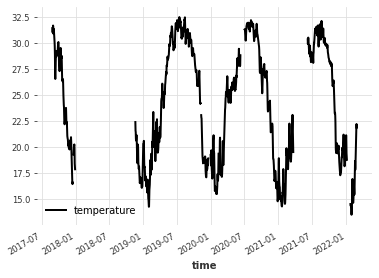

In [46]:

series.plot()

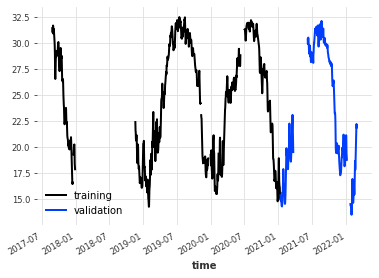

In [54]:
train, val = series.split_before(0.75)
train.plot(label="training")
val.plot(label="validation")


In [63]:
horizon = val.n_timesteps
pts_in_yr = 400

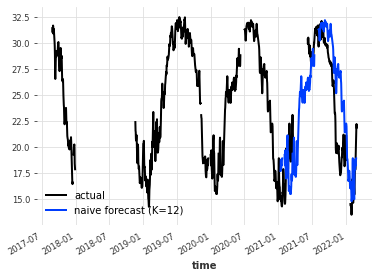

In [70]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=pts_in_yr)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(horizon)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")



# Probablistic Forecasts

/home/cboettig/.pyenv/versions/3.7.9/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/cboettig/.pyenv/versions/3.7.9/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/cboettig/.pyenv/versions/3.7.9/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


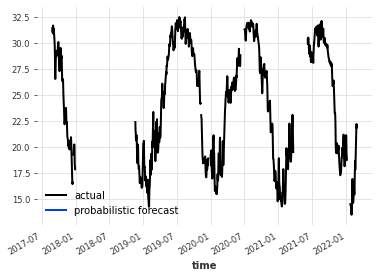

In [71]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()



Missing values will create a problem for the neural net.  We infer them first:

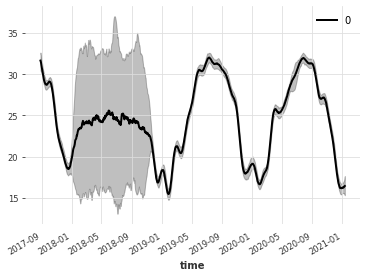

In [86]:
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF


kernel = RBF()

gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
filtered_series = gpf.filter(train, num_samples=100)

filtered_series.plot()



In [87]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood


model = TCNModel(
    input_chunk_length=400,
    output_chunk_length=100,
    random_state=42,
    likelihood=LaplaceLikelihood(),
    torch_device_str = "cuda"
)
model.trainer_params


[2022-03-21 23:52:19,766] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-03-21 23:52:19,766] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags


{'accelerator': 'gpu',
 'gpus': -1,
 'auto_select_gpus': True,
 'logger': False,
 'max_epochs': 100,
 'check_val_every_n_epoch': 10,
 'enable_checkpointing': False,
 'callbacks': []}

In [88]:

from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
train_scaled = scaler.fit_transform(filtered_series)


In [89]:
model.fit(train_scaled, epochs=400, verbose=True)

[2022-03-21 23:52:31,986] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-03-21 23:52:31,986] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-03-21 23:52:31,989] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-03-21 23:52:31,989] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-03-21 23:52:31,996] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 23:52:31,996] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-21 23:52:31,997] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progr

Epoch 399: 100%|██████████| 23/23 [00:00<00:00, 57.00it/s, loss=-1.37] 


In [90]:
pred = model.predict(n=horizon, num_samples=500)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 23it [00:00, ?it/s]


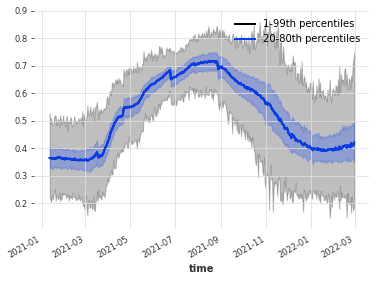

In [91]:

pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

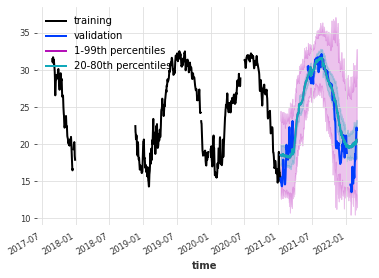

In [92]:
train.plot(label="training")
val.plot(label="validation")
pred = scaler.inverse_transform(pred)
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")
